# 1) Load data

In [51]:
import pandas as pd

# Load data
hour_df = pd.read_csv('DATA/Bike-Sharing-Dataset/hour.csv')
print(hour_df.info())
hour_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# 2) Pre-process data
## 2.1) Standarize column names

In [52]:
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'}, inplace=True)


## 2.2) Typecast Attributes

In [53]:
# date time variable 
hour_df.datetime = pd.to_datetime(hour_df.datetime)

# categorical variables
hour_df.season = hour_df.season.astype('category')
hour_df.is_holiday = hour_df.is_holiday.astype('category')
hour_df.weekday = hour_df.weekday.astype('category')
hour_df.weather_condition = hour_df.weather_condition.astype('category')
hour_df.is_workingday = hour_df.is_workingday.astype('category')
hour_df.month = hour_df.month.astype('category')
hour_df.year = hour_df.year.astype('category')
hour_df.hour = hour_df.hour.astype('category')
hour_df.head()

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 2.3) Encode Categoricals (One Hot Encoding)

In [54]:
from sklearn import preprocessing
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
        column.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded

    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series

    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df




# 3) Train-Test Split

In [55]:
from sklearn.model_selection import train_test_split 

# splitting data into training (67%) and testing (33%) parts
# NOTE: - ignoring the 'casual' and 'registered' features in the X parts
#       - the Y parts contains 'total_count' feature.
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

In [56]:
# reset index: new indexes: 0,1,... for all rows, and ADD the old indexes as a new column named 'index'
X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))


Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


# 4) Normality Test

In [57]:
from scipy import stats
import matplotlib.pyplot as plt
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sn


sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

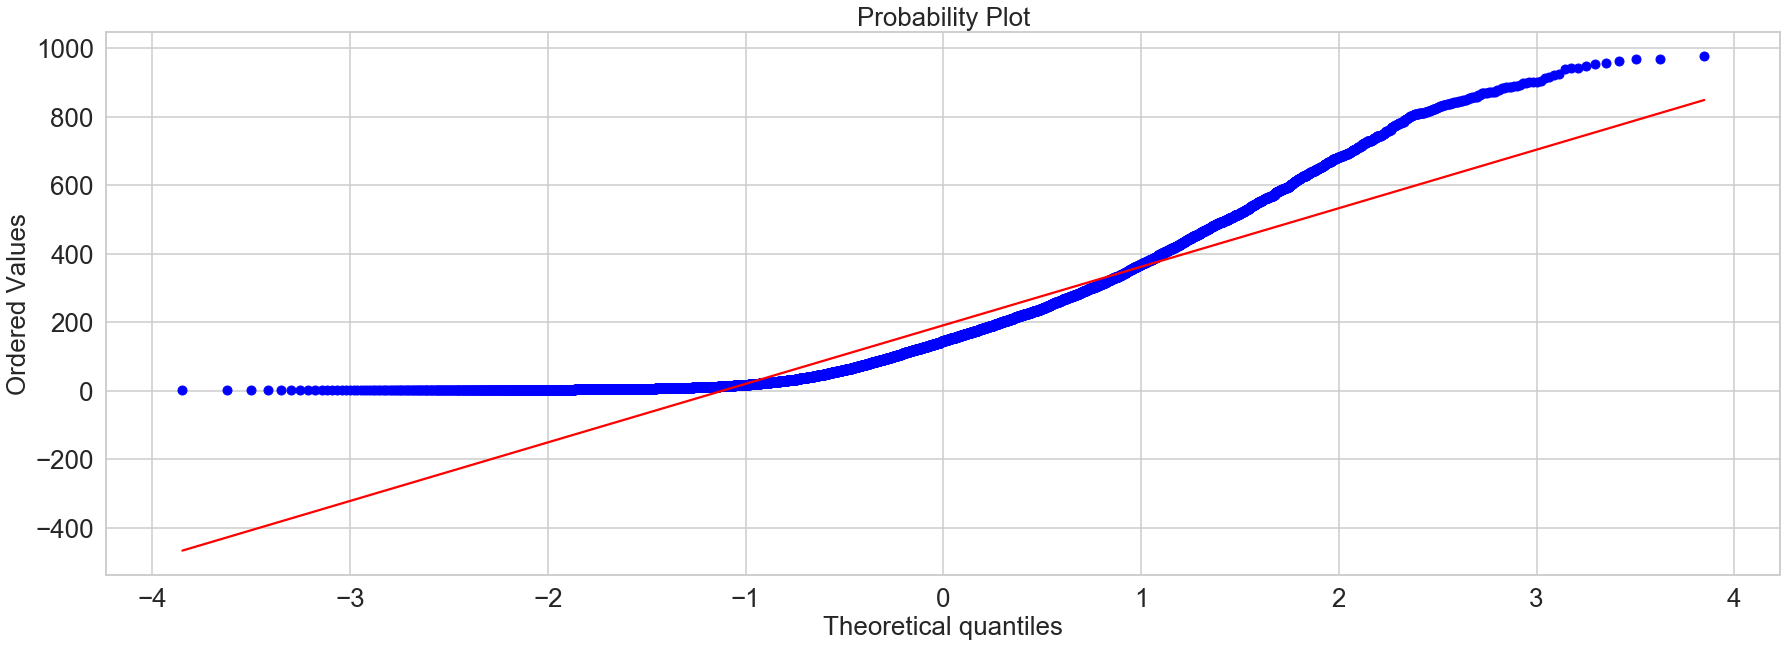

In [58]:
# make  Q-Q plot: to check how fit the y values to the normal distribution function
stats.probplot(y.total_count.tolist(), dist="norm", plot=plt)
plt.show()


In [59]:
# lists of feature names
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']



In [60]:
# create a list containing 8 dictionaries
# each dictionary has 4 keys: 
#           - 2 objects of encoding (Label & OneHot), 
#           - 1 dataframe of dummy variables for one chosen categorical feature
#           - 1 name of that chosen categorical feature
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})


/Users/DuyUyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/DuyUyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "catego

In [61]:
# example: to view dummy variables of feature 'season' after encoded
encoded_attr_list[0]['feature_df']


,season_1,season_2,season_3,season_4
0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
11638,0.0,1.0,0.0,0.0
11639,0.0,1.0,0.0,0.0
11640,0.0,0.0,1.0,0.0
11641,1.0,0.0,0.0,0.0


In [62]:
# create new dataframe 
#       including all continous (numeric) variables and dummy (categorical) variables,
#       excluding dummy (categorical) variables: 'hour','weekday','month','year'
#       HOWEVER, it still includes these (categorical) variables: 'hour','weekday','month','year' in category-type ????
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)


In [63]:
# viewing the resulting dataframe
train_df_new.head()


,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.64,0.65,0.1940,0,5,9,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.50,0.45,0.2239,13,2,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.86,0.47,0.5224,12,0,8,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.30,0.61,0.0000,2,3,2,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.54,0.19,0.4179,17,6,4,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# 5) Make Linear Regression Model

In [64]:
# reset variables for modeling
X = train_df_new
y= y.total_count.values.reshape(-1,1)

In [71]:
# make model with cross-validation 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict

lin_reg = linear_model.LinearRegression()
predicted = cross_val_predict(lin_reg, X, y, cv=10)

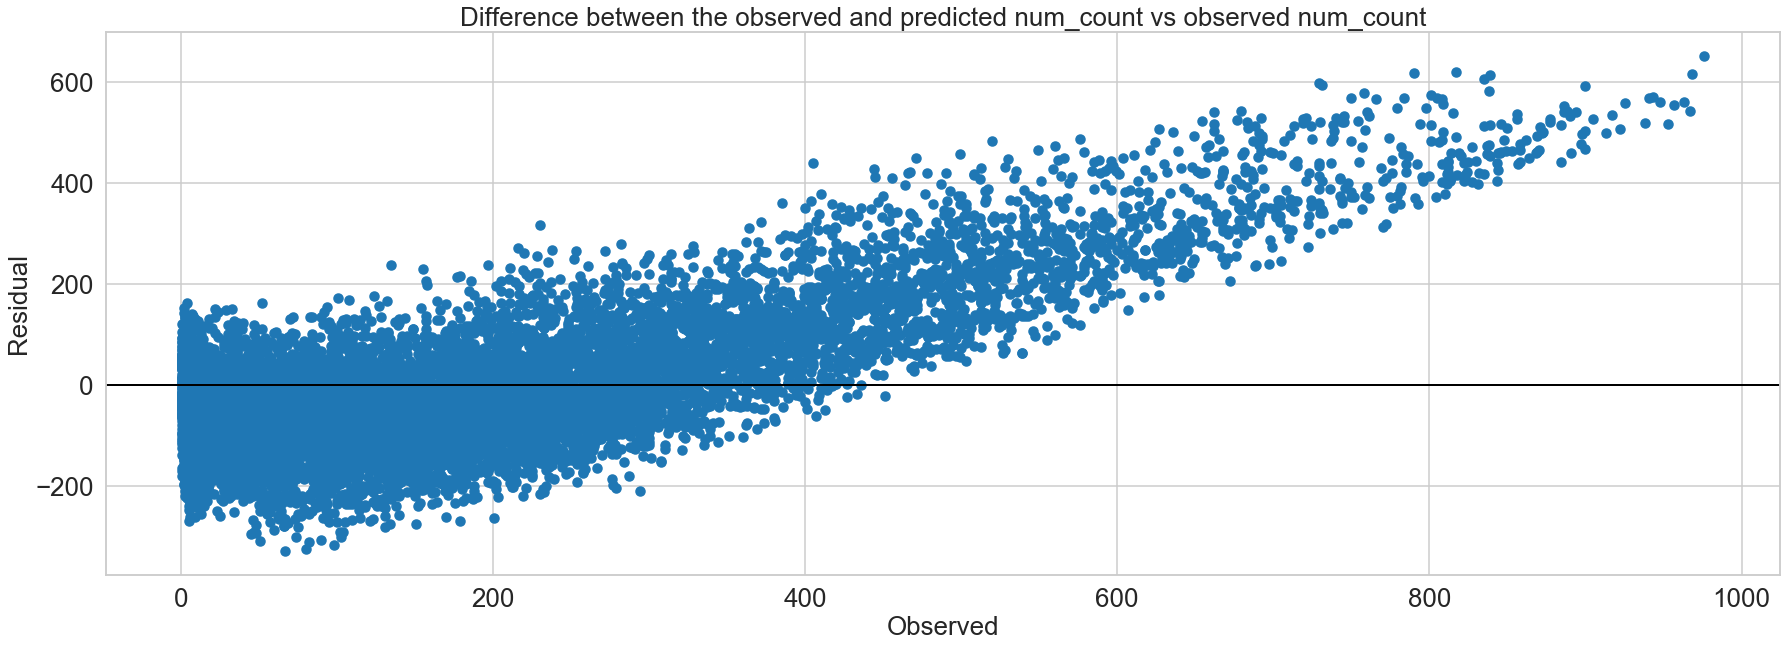

In [69]:
# Plotting the difference between the observed and predicted num_count vs observed num_count
fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color='black')
ax.set_title('Difference between the observed and predicted num_count vs. Observed num_count')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()



In [80]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')
print(f'R-squared:: {r2_scores.mean()}')
print(f'MSE:: {mse_scores.mean()}')

R-squared:: 0.39423906942549125
MSE:: -20203.751111588314


In [81]:
X.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11643 entries, 0 to 11642
Data columns (total 19 columns):
temp                   11643 non-null float64
humidity               11643 non-null float64
windspeed              11643 non-null float64
hour                   11643 non-null category
weekday                11643 non-null category
month                  11643 non-null category
year                   11643 non-null category
season_1               11643 non-null float64
season_2               11643 non-null float64
season_3               11643 non-null float64
season_4               11643 non-null float64
is_holiday_0           11643 non-null float64
is_holiday_1           11643 non-null float64
weather_condition_1    11643 non-null float64
weather_condition_2    11643 non-null float64
weather_condition_3    11643 non-null float64
weather_condition_4    11643 non-null float64
is_workingday_0        11643 non-null float64
is_workingday_1        11643 non-null float64
dtypes: categ